Este código utiliza modelos de Aprendizaje Automático sobre una base de datos de referencia, la cual puede ser encontrada en:
https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?select=creditcard.csv

Este código tiene como finalidad comparar una BD reconocida con los resultados obtenidos en nuestra BD sintética.

In [ ]:
import os
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn import metrics
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, confusion_matrix, precision_recall_curve, roc_auc_score, auc, make_scorer, roc_curve


sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# **Pre**

In [ ]:
DIR_INPUT='/ruta/'

print("Load  files")
%time transactions_df = pd.read_csv(DIR_INPUT+"creditcard.csv")
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.Class.sum()))

Load  files
CPU times: user 2.52 s, sys: 239 ms, total: 2.76 s
Wall time: 10.4 s
284807 transactions loaded, containing 492 fraudulent transactions


In [ ]:
n_folds = 4

In [ ]:
output_feature = 'Class'
input_features = transactions_df.columns[:-1].tolist()

# **Modelos**

## Regresión Logística

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(transactions_df[input_features],
                                                        transactions_df[output_feature],
                                                        test_size=0.2,
                                                        shuffle=False,
                                                        random_state=42)

In [ ]:
model = LogisticRegression(random_state=0)

In [ ]:
tscv = TimeSeriesSplit(n_splits=n_folds)

In [ ]:
precision_scores = []
recall_scores = []

In [ ]:
# Definir el threshold
threshold = 0.01

# Iterar sobre los splits de la validación cruzada
for train_index, test_index in tscv.split(X_train):
    # Obtener los conjuntos de entrenamiento y prueba para este split
    X_train_cv, X_valid_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_valid_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    # Sobremuestrear la clase minoritaria en el conjunto de entrenamiento
    smote = SMOTE(random_state=0)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_cv, y_train_cv)

    # Entrenar el modelo con los datos de entrenamiento resampleados
    model.fit(X_train_resampled, y_train_resampled)

    # Predecir las probabilidades en el conjunto de validación
    y_pred_prob_valid = model.predict_proba(X_valid_cv)[:, 1]

    # Convertir las probabilidades en etiquetas usando el threshold
    y_pred_valid = (y_pred_prob_valid > threshold).astype(int)

    # Calcular precision y recall
    precision = precision_score(y_valid_cv, y_pred_valid)
    recall = recall_score(y_valid_cv, y_pred_valid)

    # Almacenar los resultados
    precision_scores.append(precision)
    recall_scores.append(recall)

In [ ]:
# Precisión y recall promedio

average_precision = sum(precision_scores) / len(precision_scores)
average_recall = sum(recall_scores) / len(recall_scores)

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)

Average Precision: 0.024561770299294287
Average Recall: 0.9069775067217523


In [ ]:
y_pred_proba_test = model.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva

In [ ]:
# Cantidad de elementos por clase original test set

unique_values, counts = np.unique(y_test, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Clase {value}: {count} ocurrencias")

print("Longitud test set: ", len(X_test))

Clase 0: 56887 ocurrencias
Clase 1: 75 ocurrencias
Longitud test set:  56962


In [ ]:
# Cantidad de elementos por clase con umbral de 0.5 en predicción de fraudes en test set

y_pred_test = (y_pred_proba_test >= 0.5).astype(int)
unique_values, counts = np.unique(y_pred_test, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Clase {value}: {count} ocurrencias")

print("Longitud test set: ", len(X_test))

Clase 0: 56808 ocurrencias
Clase 1: 154 ocurrencias
Longitud test set:  56962


In [ ]:
# Métricas con diversos umbrales

thresholds = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

for threshold in thresholds:
  y_pred_test = (y_pred_proba_test >= threshold).astype(int)
  precision_test = precision_score(y_test, y_pred_test)
  recall_test = recall_score(y_test, y_pred_test)
  cm_test = confusion_matrix(y_test, y_pred_test)

  print("THRESHOLD: ", threshold)
  print("Test Precision:", precision_test)
  print("Test Recall:", recall_test)
  print("Test CM:", cm_test)

THRESHOLD:  0.5
Test Precision: 0.4025974025974026
Test Recall: 0.8266666666666667
Test CM: [[56795    92]
 [   13    62]]
THRESHOLD:  0.1
Test Precision: 0.12840466926070038
Test Recall: 0.88
Test CM: [[56439   448]
 [    9    66]]
THRESHOLD:  0.05
Test Precision: 0.06767676767676768
Test Recall: 0.8933333333333333
Test CM: [[55964   923]
 [    8    67]]
THRESHOLD:  0.01
Test Precision: 0.018729641693811076
Test Recall: 0.92
Test CM: [[53272  3615]
 [    6    69]]
THRESHOLD:  0.005
Test Precision: 0.010798479087452472
Test Recall: 0.9466666666666667
Test CM: [[50383  6504]
 [    4    71]]
THRESHOLD:  0.001
Test Precision: 0.003547273329234262
Test Recall: 1.0
Test CM: [[35819 21068]
 [    0    75]]


56662
0.9999080210423179


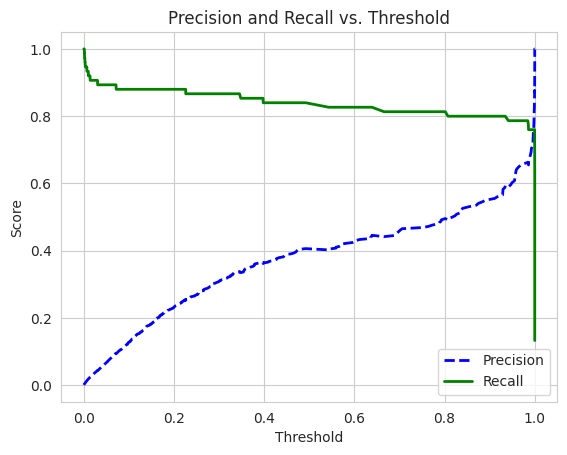

In [ ]:
# Curva precisión, recall vs umbral

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

best_index = np.argmax(f1_scores)
print(best_index)

best_threshold = thresholds[best_index]
print(best_threshold)

sns.set_style("whitegrid")

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
#plt.plot(best_threshold, precisions[best_index], 'ro', label=f"Best F1-score\nThreshold: {best_threshold:.3f}\nPrecision: {precisions[best_index]:.3f}\nRecall: {recalls[best_index]:.3f}")

plt.legend(loc="center right", fontsize=16)
plt.grid(True)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.show()

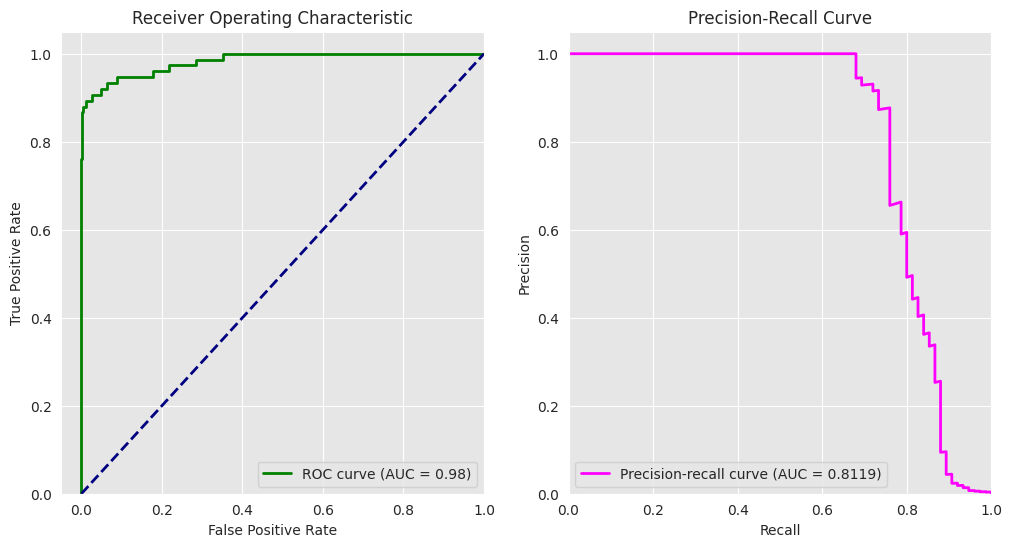

In [ ]:
# curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
roc_auc = auc(fpr, tpr)

# precisión-recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
pr_auc = auc(recall, precision)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Gráfica ROC en la columna izquierda
axs[0].plot(fpr, tpr, color='#008000', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[0].set_xlim([-0.05, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('Receiver Operating Characteristic')
axs[0].legend(loc="lower right")

# Gráfica de precisión-recall en la columna derecha
axs[1].plot(recall, precision, color='#FF00FF', lw=2, label='Precision-recall curve (AUC = {:.4f})'.format(pr_auc))
axs[1].set_xlim([0.0, 1])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve')
axs[1].legend(loc="lower left")

## Árbol de Decisión

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(transactions_df[input_features],
                                                        transactions_df[output_feature],
                                                        test_size=0.2,
                                                        shuffle=False,
                                                        random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=4, random_state=0)

In [ ]:
tscv = TimeSeriesSplit(n_splits=n_folds)

In [ ]:
precision_scores = []
recall_scores = []

In [ ]:
# Definir el threshold
threshold = 0.01

# Iterar sobre los splits de la validación cruzada
for train_index, test_index in tscv.split(X_train):
    # Obtener los conjuntos de entrenamiento y prueba para este split
    X_train_cv, X_valid_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_valid_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    # Sobremuestrear la clase minoritaria en el conjunto de entrenamiento
    smote = SMOTE(random_state=0)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_cv, y_train_cv)

    # Entrenar el modelo con los datos de entrenamiento resampleados
    model.fit(X_train_resampled, y_train_resampled)

    # Predecir las probabilidades en el conjunto de validación
    y_pred_prob_valid = model.predict_proba(X_valid_cv)[:, 1]

    # Convertir las probabilidades en etiquetas usando el threshold
    y_pred_valid = (y_pred_prob_valid > threshold).astype(int)

    # Calcular precision y recall
    precision = precision_score(y_valid_cv, y_pred_valid)
    recall = recall_score(y_valid_cv, y_pred_valid)

    # Almacenar los resultados
    precision_scores.append(precision)
    recall_scores.append(recall)

In [ ]:
# Precisión y recall promedio

average_precision = sum(precision_scores) / len(precision_scores)
average_recall = sum(recall_scores) / len(recall_scores)

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)

Average Precision: 0.0057414587637771245
Average Recall: 0.9361064659977704


In [ ]:
y_pred_proba_test = model.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva

In [ ]:
# Cantidad de elementos por clase original test set

unique_values, counts = np.unique(y_test, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Clase {value}: {count} ocurrencias")

print("Longitud test set: ", len(X_test))

Clase 0: 56887 ocurrencias
Clase 1: 75 ocurrencias
Longitud test set:  56962


In [ ]:
# Cantidad de elementos por clase con umbral de 0.5 en predicción de fraudes en test set

y_pred_test = (y_pred_proba_test >= 0.5).astype(int)
unique_values, counts = np.unique(y_pred_test, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Clase {value}: {count} ocurrencias")

print("Longitud test set: ", len(X_test))

Clase 0: 56350 ocurrencias
Clase 1: 612 ocurrencias
Longitud test set:  56962


In [ ]:
# Métricas con diversos umbrales

thresholds = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

for threshold in thresholds:
  y_pred_test = (y_pred_proba_test >= threshold).astype(int)
  precision_test = precision_score(y_test, y_pred_test)
  recall_test = recall_score(y_test, y_pred_test)
  cm_test = confusion_matrix(y_test, y_pred_test)

  print("THRESHOLD: ", threshold)
  print("Test Precision:", precision_test)
  print("Test Recall:", recall_test)
  print("Test CM:", cm_test)

THRESHOLD:  0.5
Test Precision: 0.09967320261437909
Test Recall: 0.8133333333333334
Test CM: [[56336   551]
 [   14    61]]
THRESHOLD:  0.1
Test Precision: 0.006337709370755998
Test Recall: 0.9333333333333333
Test CM: [[45912 10975]
 [    5    70]]
THRESHOLD:  0.05
Test Precision: 0.0052612612612612615
Test Recall: 0.9733333333333334
Test CM: [[43085 13802]
 [    2    73]]
THRESHOLD:  0.01
Test Precision: 0.0013209341646412342
Test Recall: 1.0
Test CM: [[  184 56703]
 [    0    75]]
THRESHOLD:  0.005
Test Precision: 0.0013209341646412342
Test Recall: 1.0
Test CM: [[  184 56703]
 [    0    75]]
THRESHOLD:  0.001
Test Precision: 0.0013209341646412342
Test Recall: 1.0
Test CM: [[  184 56703]
 [    0    75]]


14
1.0


<ipython-input-44-037e2645d9ba>:2: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


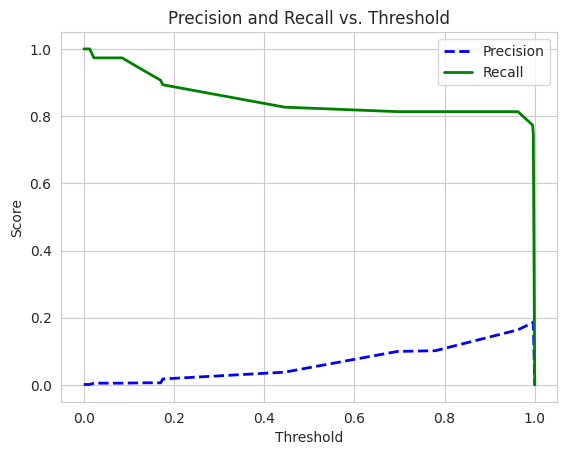

In [ ]:
# Curva precisión, recall vs umbral

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

best_index = np.argmax(f1_scores)
print(best_index)

best_threshold = thresholds[best_index]
print(best_threshold)

sns.set_style("whitegrid")

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
# plt.plot(best_threshold, precisions[best_index], 'ro', label=f"Best F1-score\nThreshold: {best_threshold:.3f}\nPrecision: {precisions[best_index]:.3f}\nRecall: {recalls[best_index]:.3f}")

plt.legend(loc="center right", fontsize=16)
plt.grid(True)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.show()

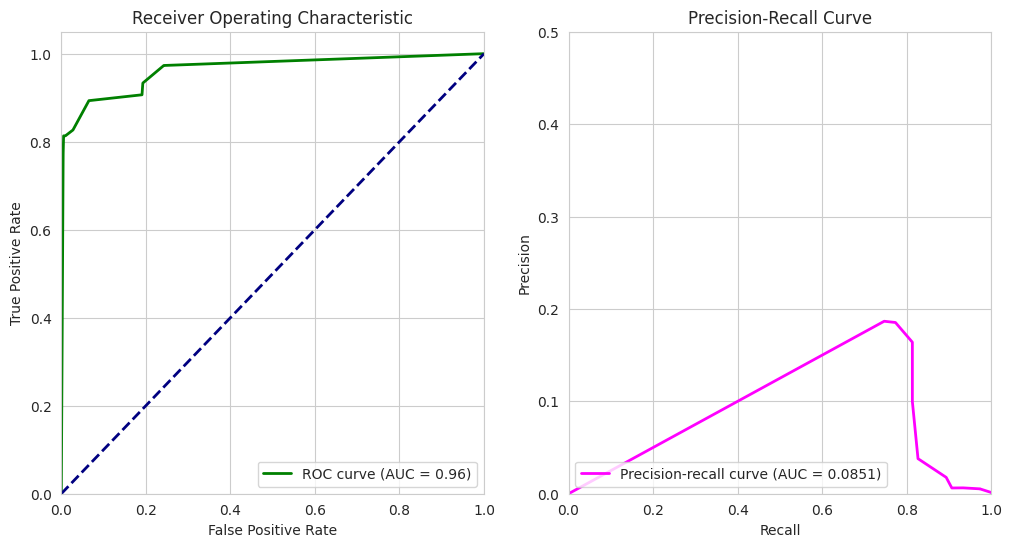

In [ ]:
# curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
roc_auc = auc(fpr, tpr)

# precisión-recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
pr_auc = auc(recall, precision)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Gráfica ROC en la columna izquierda
axs[0].plot(fpr, tpr, color='#008000', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('Receiver Operating Characteristic')
axs[0].legend(loc="lower right")

# Gráfica de precisión-recall en la columna derecha
axs[1].plot(recall, precision, color='#FF00FF', lw=2, label='Precision-recall curve (AUC = {:.4f})'.format(pr_auc))
axs[1].set_xlim([0.0, 1])
axs[1].set_ylim([0.0, 0.5])
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve')
axs[1].legend(loc="lower left")

## Random Forest

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(transactions_df[input_features],
                                                        transactions_df[output_feature],
                                                        test_size=0.2,
                                                        shuffle=False,
                                                        random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=0)

In [ ]:
tscv = TimeSeriesSplit(n_splits=n_folds)

In [ ]:
precision_scores = []
recall_scores = []

In [ ]:
# Definir el threshold
threshold = 0.01

# Iterar sobre los splits de la validación cruzada
for train_index, test_index in tscv.split(X_train):
    # Obtener los conjuntos de entrenamiento y prueba para este split
    X_train_cv, X_valid_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_valid_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    # Sobremuestrear la clase minoritaria en el conjunto de entrenamiento
    smote = SMOTE(random_state=0)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_cv, y_train_cv)

    # Entrenar el modelo con los datos de entrenamiento resampleados
    model.fit(X_train_resampled, y_train_resampled)

    # Predecir las probabilidades en el conjunto de validación
    y_pred_prob_valid = model.predict_proba(X_valid_cv)[:, 1]

    # Convertir las probabilidades en etiquetas usando el threshold
    y_pred_valid = (y_pred_prob_valid > threshold).astype(int)

    # Calcular precision y recall
    precision = precision_score(y_valid_cv, y_pred_valid)
    recall = recall_score(y_valid_cv, y_pred_valid)

    # Almacenar los resultados
    precision_scores.append(precision)
    recall_scores.append(recall)

In [ ]:
# Precisión y recall promedio

average_precision = sum(precision_scores) / len(precision_scores)
average_recall = sum(recall_scores) / len(recall_scores)

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)

Average Precision: 0.02282803229143028
Average Recall: 0.8806766017443767


In [ ]:
y_pred_proba_test = model.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva

In [ ]:
# Cantidad de elementos por clase original test set

unique_values, counts = np.unique(y_test, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Clase {value}: {count} ocurrencias")

print("Longitud test set: ", len(X_test))

Clase 0: 56887 ocurrencias
Clase 1: 75 ocurrencias
Longitud test set:  56962


In [ ]:
# Cantidad de elementos por clase con umbral de 0.5 en predicción de fraudes en test set

y_pred_test = (y_pred_proba_test >= 0.5).astype(int)
unique_values, counts = np.unique(y_pred_test, return_counts=True)

for value, count in zip(unique_values, counts):
    print(f"Clase {value}: {count} ocurrencias")

print("Longitud test set: ", len(X_test))

Clase 0: 56899 ocurrencias
Clase 1: 63 ocurrencias
Longitud test set:  56962


In [ ]:
# Métricas con diversos umbrales

thresholds = [0.5, 0.25, 0.1, 0.05, 0.01, 0.005, 0.001]

for threshold in thresholds:
  y_pred_test = (y_pred_proba_test >= threshold).astype(int)
  precision_test = precision_score(y_test, y_pred_test)
  recall_test = recall_score(y_test, y_pred_test)
  cm_test = confusion_matrix(y_test, y_pred_test)

  print("THRESHOLD: ", threshold)
  print("Test Precision:", precision_test)
  print("Test Recall:", recall_test)
  print("Test CM:", cm_test)

THRESHOLD:  0.5
Test Precision: 0.9047619047619048
Test Recall: 0.76
Test CM: [[56881     6]
 [   18    57]]
THRESHOLD:  0.25
Test Precision: 0.8055555555555556
Test Recall: 0.7733333333333333
Test CM: [[56873    14]
 [   17    58]]
THRESHOLD:  0.1
Test Precision: 0.3592814371257485
Test Recall: 0.8
Test CM: [[56780   107]
 [   15    60]]
THRESHOLD:  0.05
Test Precision: 0.10465116279069768
Test Recall: 0.84
Test CM: [[56348   539]
 [   12    63]]
THRESHOLD:  0.01
Test Precision: 0.00869336143308746
Test Recall: 0.88
Test CM: [[49361  7526]
 [    9    66]]
THRESHOLD:  0.005
Test Precision: 0.00869336143308746
Test Recall: 0.88
Test CM: [[49361  7526]
 [    9    66]]
THRESHOLD:  0.001
Test Precision: 0.00869336143308746
Test Recall: 0.88
Test CM: [[49361  7526]
 [    9    66]]


29
0.51


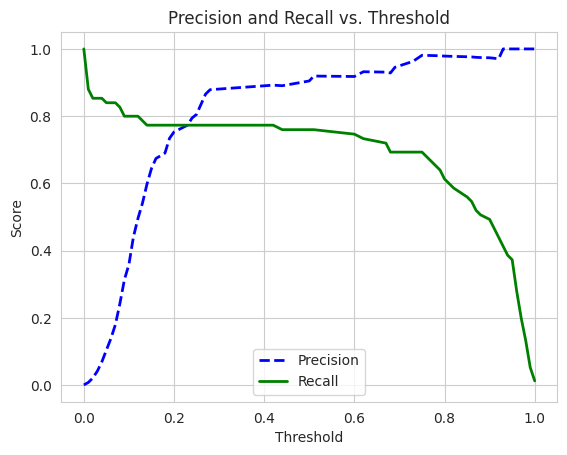

In [ ]:
# Curva precisión, recall vs umbral

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

best_index = np.argmax(f1_scores)
print(best_index)

best_threshold = thresholds[best_index]
print(best_threshold)

sns.set_style("whitegrid")

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
# plt.plot(best_threshold, precisions[best_index], 'ro', label=f"Best F1-score\nThreshold: {best_threshold:.3f}\nPrecision: {precisions[best_index]:.3f}\nRecall: {recalls[best_index]:.3f}")

plt.legend(loc="center right", fontsize=16)
plt.grid(True)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.show()

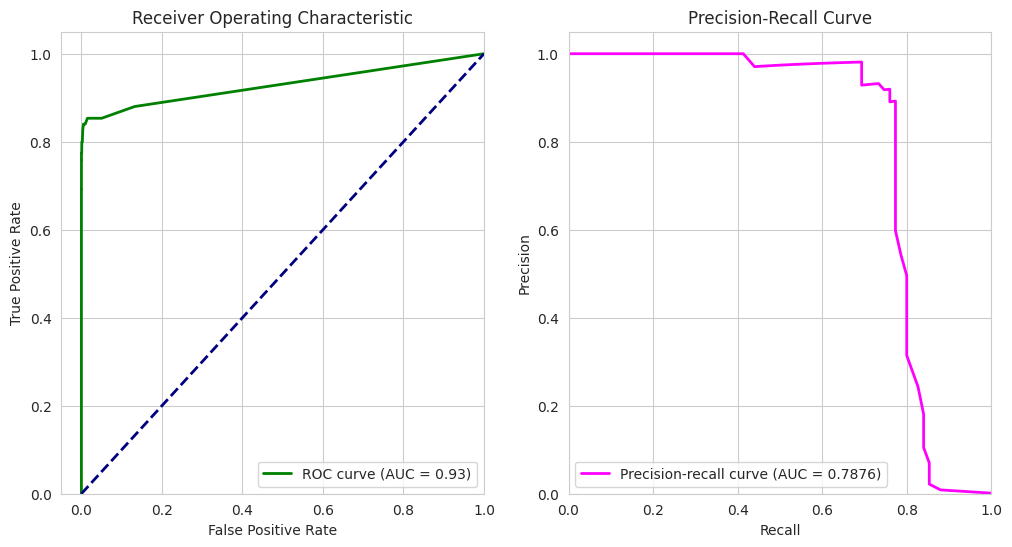

In [ ]:
# curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
roc_auc = auc(fpr, tpr)

# precisión-recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
pr_auc = auc(recall, precision)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Gráfica ROC en la columna izquierda
axs[0].plot(fpr, tpr, color='#008000', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[0].set_xlim([-0.05, 1.00])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('Receiver Operating Characteristic')
axs[0].legend(loc="lower right")

# Gráfica de precisión-recall en la columna derecha
axs[1].plot(recall, precision, color='#FF00FF', lw=2, label='Precision-recall curve (AUC = {:.4f})'.format(pr_auc))
axs[1].set_xlim([0.0, 1])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision-Recall Curve')
axs[1].legend(loc="lower left")